# 5.3 Using a pretrained convnet

A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A __pretrained network__ is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computervision problems, even though these new problems may involve completely different classes than those of the original task. For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, __including different species of cats and dogs__, and __you can thus expect to
perform well on the dogs-versus-cats classification problem__.

You’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet. Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, I chose it because its architecture is similar to what you’re already familiar with and is easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesy model names—VGG, ResNet, Inception, Inception-ResNet, Xception, and so on; you’ll get used to them, because they will come up frequently if you keep doing deep learning for computer vision.

There are __two ways to use a pretrained network__: __feature extraction__ and __fine-tuning__. We’ll cover both of them. Let’s start with feature extraction.

## 5.3.1 Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As you saw previously, convnets used for image classification comprise two parts:
they __start with__ a __series of pooling__ and __convolution layers__, and they __end with__ a __densely connected classifier__. The __first part__ is called the __convolutional base__ of the model. In the case of convnets, __feature extraction__ consists of __taking the convolutional base__ of a previously trained network, running the new data through it, and training a new classifier on top of the output.

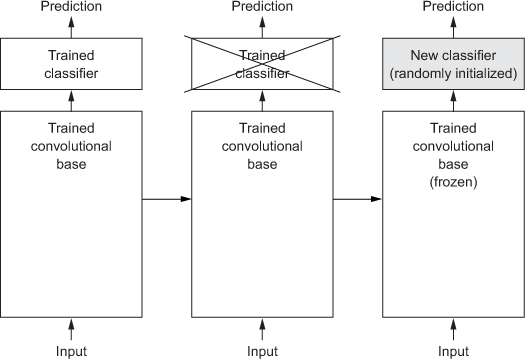

Why only __reuse the convolutional base__? Could you __reuse the densely connected classifier__ as well? In general, doing so should be __avoided__. The reason is that __the representations learned by the convolutional base__ are likely to be __more generic and therefore more reusable__: the __feature maps of a convnet are presence maps of generic concepts over a picture__, which is likely to be useful regardless of the computer-vision problem at hand. __But the representations learned by the classifier__ will necessarily be __specific to the set of classes on which the model was trained__—they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations
found in densely connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. __Layers that come earlier__ in the model __extract local, highly generic feature maps__ (such as visual edges, colors, and textures), whereas __layers that are higher up__ __extract more-abstract concepts__ (such as “cat ear” or “dog eye”). __So if your new dataset__ __differs a lot__ from the __dataset on which the original model was trained__, __you may be better__ off __using only the first few layers__ of the model __to do feature extraction__, __rather than using the entire convolutional base__.

In this case, because the __ImageNet__ class set __contains multiple dog and cat classes__, it’s __likely to be beneficial__ to __reuse the information__ contained __in the densely connected layers of the original model__. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

The VGG16 model, among others, __comes prepackaged with Keras__. You can __import__ it from the __keras.applications__ module. Here’s the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of keras .applications:

* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let’s instantiate the VGG16 model.

In [1]:
# Instantiating the VGG16 convolutional base
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


You pass three arguments to the constructor:
* __weights__ specifies the weight checkpoint from which to initialize the model.
* __include_top__ refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
* __input_shape__ is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

Here’s the detail of the architecture of the VGG16 convolutional base. It’s similar to the simple convnets you’re already familiar with:

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll stick a densely connected classifier.
At this point, there are two ways you could proceed:

* Running the __convolutional base over your dataset__, __recording its output to a Numpy array on disk__, and then __using this data as input to a standalone, densely connected classifier__ similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires __running the convolutional base once for every input image__, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.

* __Extending the model__ you have (conv_base) __by adding Dense layers on top__, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far __more expensive than the first__.

We’ll cover both techniques. Let’s walk through the code required to set up the __first one__: recording the output of conv_base on your data and using these outputs as inputs to a new model.

### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

You’ll start by running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. You’ll __extract features__ from these images by calling the __predict__ method of the __conv_base__ model.

In [3]:
# Extracting features using the pretrained convolutional base
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

base_dir = os.listdir(Path.cwd())[len(os.listdir(Path.cwd()))-2]
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        
        if i * batch_size >= sample_count:
            # Note that because generators
            # yield data indefinitely in a loop,
            # you must break after every
            # image has been seen once.
            break
    
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

In [6]:
# Defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6001 - acc: 0.6680 - val_loss: 0.4324 - val_acc: 0.8340
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4154 - acc: 0.8125 - val_loss: 0.3489 - val_acc: 0.8680
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3353 - acc: 0.8515 - val_loss: 0.3101 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3144 - acc: 0.8660 - val_loss: 0.2882 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2808 - acc: 0.8840 - val_loss: 0.2747 - val_acc: 0.8940
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2596 - acc: 0.8900 - val_loss: 0.2637 - v

Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU. Let’s look at the loss and accuracy curves during training

In [7]:
# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(8, 8))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 800x800 with 1 Axes>

<Figure size 800x800 with 1 Axes>

You reach a validation accuracy of about 90%—much better than you achieved in the previous section with the small model trained from scratch. But the __plots also indicate__ that you’re __overfitting__ almost __from the start—despite using dropout__ with a fairly large rate. That’s because this technique __doesn’t use data augmentation__, which is essential for preventing overfitting with small image datasets.

### FEATURE EXTRACTION WITH DATA AUGMENTATION

Now, let’s review the second technique I mentioned for doing feature extraction, which is much slower and more expensive, but which allows you to use data augmentation during training: __extending the conv_base__ model and __running it end to end__ on the inputs.

__NOTE__ This technique is so expensive that you should only attempt it if you have access to a GPU—it’s absolutely intractable on CPU. If you can’t run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like conv_base) to a Sequential model just like you would add a layer.

In [13]:
# Adding a densely connected classifier on top of the convolutional base
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what the model looks like now:

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier you’re adding on top has 2 million parameters.

Before you compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a network by setting its __trainable__ attribute to False:

In [10]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [11]:
conv_base.trainable = False

In [12]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, __only the weights from the two Dense layers__ that you added will be trained. That’s a total of __four weight__ tensors: __two per layer (the main weight matrix and the bias vector)__. Note that in order for these changes to take effect, you must first compile the model. __If you ever modify weight trainability__ after compilation, __you should then recompile the model__, or these changes will be ignored.

Now you can start training your model, with the same data-augmentation configuration that you used in the previous example.

In [ ]:
# Training the model end to end with a frozen convolutional base
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note that the validation data shouldn’t be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 99/100 [============================>.] - ETA: 2s - loss: 0.5826 - acc: 0.7051

Let’s plot the results again. As you can see, you reach a validation accuracy of about 96%. This is much better than you achieved with the small convnet trained from scratch.

## 5.3.2 Fine-tuning